In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, metrics, optimizers, losses, activations
import matplotlib.pyplot as plt
from IPython.display import clear_output

2023-05-30 21:57:17.719136: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 21:57:17.742248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 21:57:18.115796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(train, valid, test), info = tfds.load(
    "oxford_iiit_pet", with_info=True, split=["train", "test[:30%]", "test[30%:]"]
)

2023-05-30 21:57:18.828456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 21:57:18.845863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-30 21:57:18.845946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
NUM_BATCHES = 64

In [4]:
def load_and_normalize_img(image, mask):
    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(
        mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return tf.cast(image, tf.float32) / 255.0, tf.subtract(mask, [1])

In [5]:
ds_train = train.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [6]:
ds_valid = valid.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [7]:
ds_test = test.map(
    lambda ds: (
        load_and_normalize_img(ds["image"], ds["segmentation_mask"]),
        ds["file_name"],
        ds["label"],
        ds["species"],
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip("horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip("horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [9]:
train_batches = (
    ds_train.map(lambda x, y, z, w: (x[0], x[1]))
    .cache()
    .shuffle(info.splits["train"].num_examples)
    .batch(NUM_BATCHES)
    .map(Augment(), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_batches = (
    ds_valid.map(lambda x, y, z, w: (x[0], x[1]))
    .batch(NUM_BATCHES)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

2023-05-30 21:57:19.719285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]
2023-05-30 21:57:19.719542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype resource
	 [[{{node Placeholder/_34}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


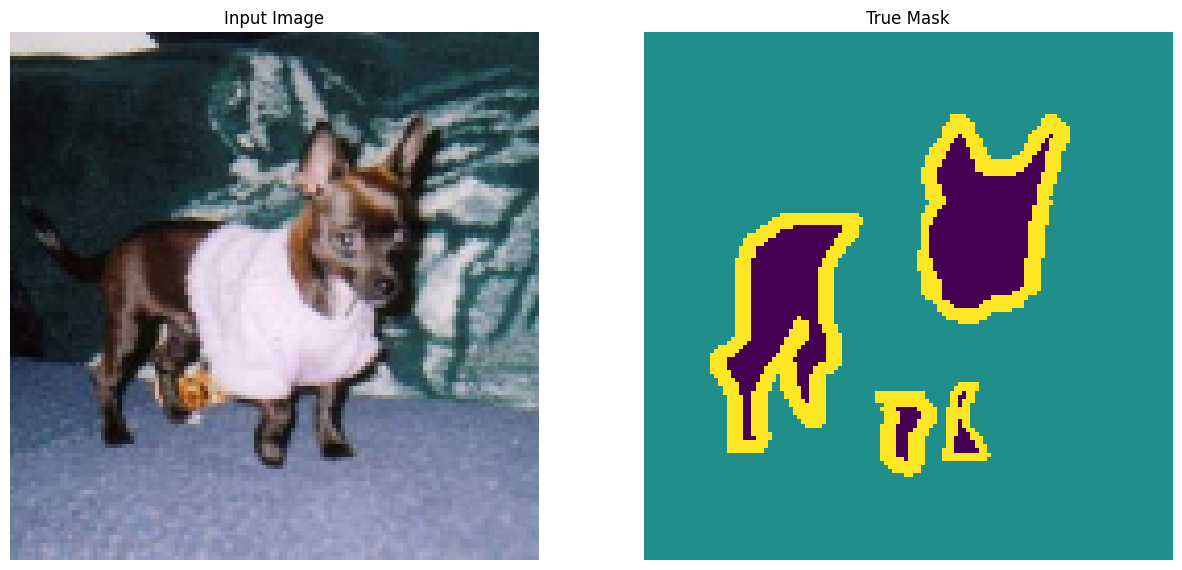

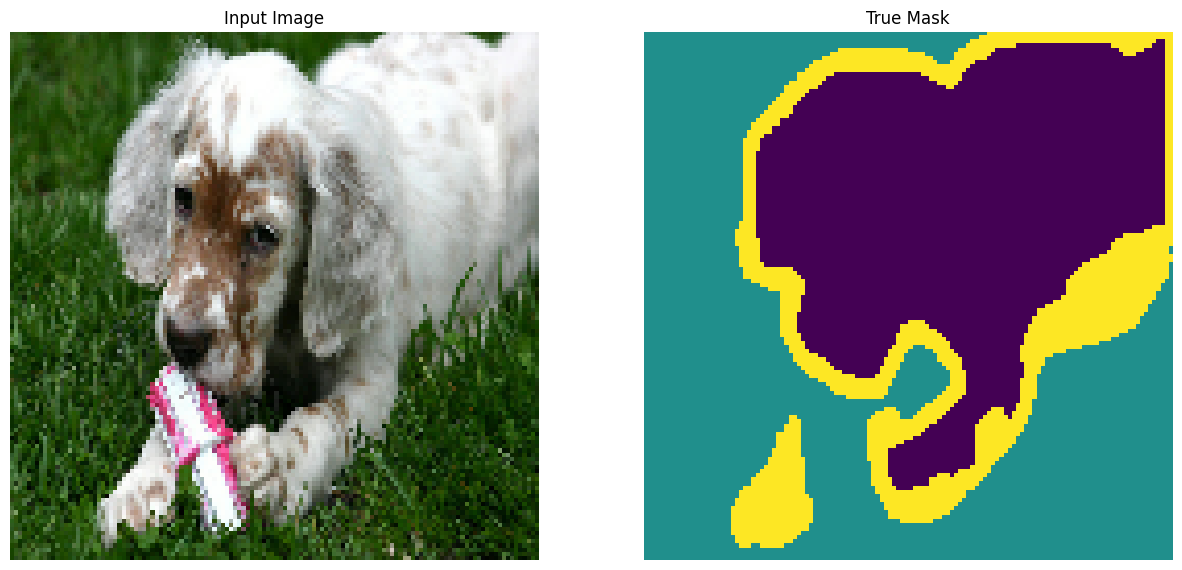

In [11]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [12]:
def sample_weights(image, label):
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights / tf.reduce_sum(class_weights)

    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [13]:
train_batches.map(sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

### U-Net as shown during lecture + BatchNormalization

In [14]:
def double_convolution(layer, filters):
    layer = layers.Conv2D(
        filters,
        3,
        padding="same",
        activation=activations.relu,
        kernel_initializer="he_normal",
    )(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Conv2D(
        filters,
        3,
        padding="same",
        activation=activations.relu,
        kernel_initializer="he_normal",
    )(layer)
    layer = layers.BatchNormalization()(layer)

    return layer


def downsample(layer, filters):
    conv = double_convolution(layer, filters)
    pool = layers.MaxPool2D(2)(conv)
    pool = layers.Dropout(0.3)(pool)
    return conv, pool


def upsample(layer, previous_features, filters):
    layer = layers.Conv2DTranspose(filters, 3, 2, padding="same")(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.concatenate([layer, previous_features])
    layer = layers.Dropout(0.3)(layer)
    return layer


def get_model():
    inputs = layers.Input(shape=(128, 128, 3))
    c1, p1 = downsample(inputs, 64)
    c2, p2 = downsample(p1, 128)
    c3, p3 = downsample(p2, 256)
    c4, p4 = downsample(p3, 512)
    bottleneck = double_convolution(p4, 1024)
    u4 = upsample(bottleneck, c4, 512)
    u3 = upsample(u4, c3, 256)
    u2 = upsample(u3, c2, 128)
    u1 = upsample(u2, c1, 64)
    outputs = layers.Conv2D(3, 3, padding="same", activation=activations.softmax)(u1)
    unet_model = tf.keras.Model(inputs, outputs)
    return unet_model


tf.keras.backend.clear_session()

model = get_model()

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics.SparseCategoricalAccuracy(),
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
print(tf.keras.utils.plot_model(model,expand_nested=True ,show_shapes=True))

<IPython.core.display.Image object>


In [16]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...])),
            ]
        )

2023-05-30 21:57:21.778705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900


1/1 [==============================] - 1s 1s/step


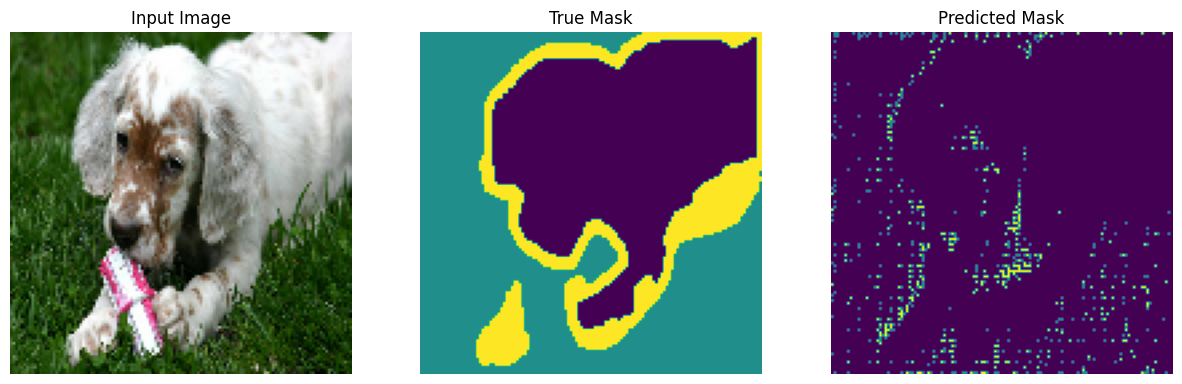

In [17]:
show_predictions()

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

1/1 [==============================] - 0s 11ms/step


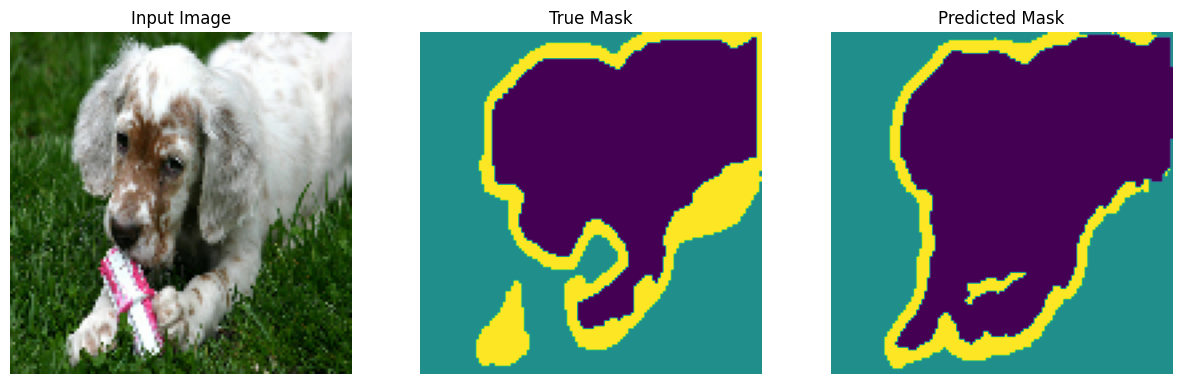


Sample Prediction after epoch 15

58/58 [==============================] - 15s 250ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.8714 - val_loss: 0.4468 - val_sparse_categorical_accuracy: 0.8444


In [19]:
model_history = model.fit(
    train_batches.map(sample_weights),
    epochs=15,
    validation_data=valid_batches,
    callbacks=[DisplayCallback()],
)

model.save("oxford_pets.h5")

Text(0.5, 1.0, 'Training and Validation Accuracy')

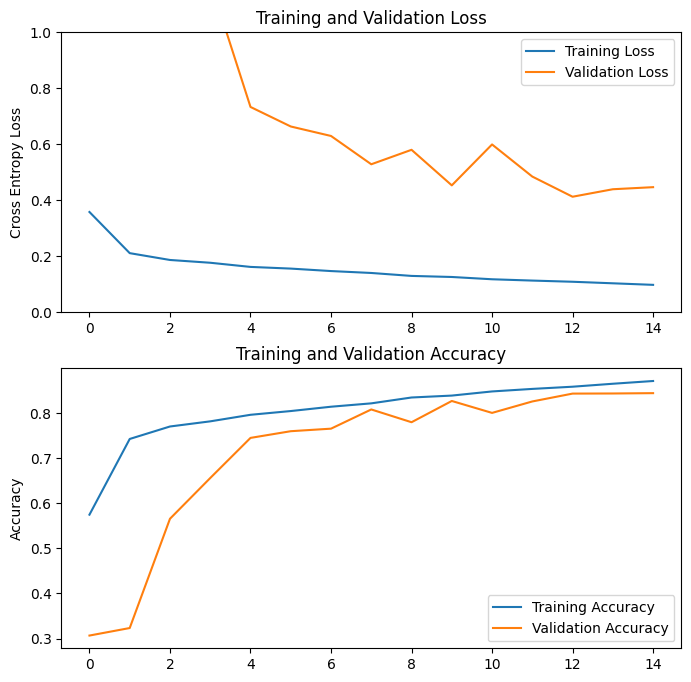

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['sparse_categorical_accuracy']
val_acc = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.ylim([0.0, 1.0])
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

In [21]:
test_batches = (
    ds_test.map(lambda x, y, z, w: (x[0], x[1]))
    .batch(NUM_BATCHES)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [22]:
loss, accuracy = model.evaluate(test_batches, verbose=1)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

 2/41 [>.............................] - ETA: 2s - loss: 0.3958 - sparse_categorical_accuracy: 0.8550

2023-05-30 22:01:08.398406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [3]
	 [[{{node Placeholder/_2}}]]
2023-05-30 22:01:08.398606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [3]
	 [[{{node Placeholder/_2}}]]


41/41 [==============================] - 3s 65ms/step - loss: 0.4336 - sparse_categorical_accuracy: 0.8476
Loss:  0.433611661195755
Accuracy:  0.847647488117218


### 5 predictions

2023-05-30 22:21:59.369546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [3]
	 [[{{node Placeholder/_3}}]]
2023-05-30 22:21:59.369902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [3]
	 [[{{node Placeholder/_2}}]]


2/2 [==============================] - 0s 29ms/step


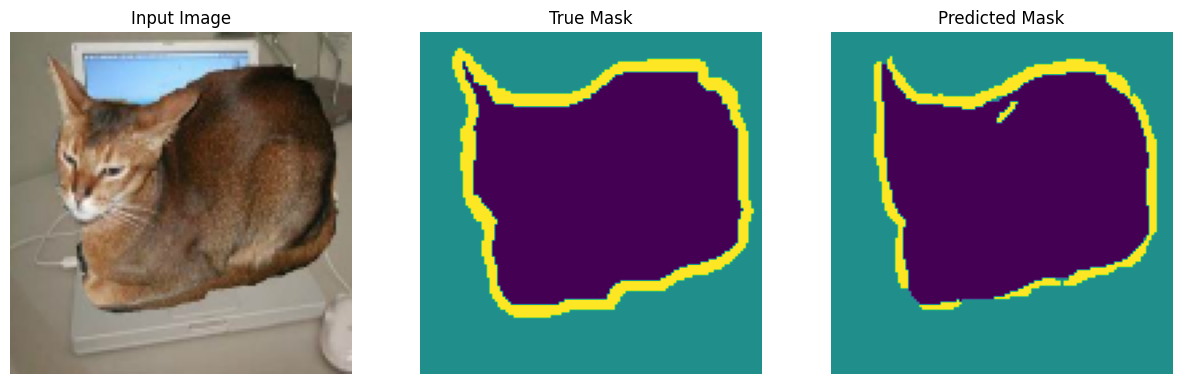

2/2 [==============================] - 0s 28ms/step


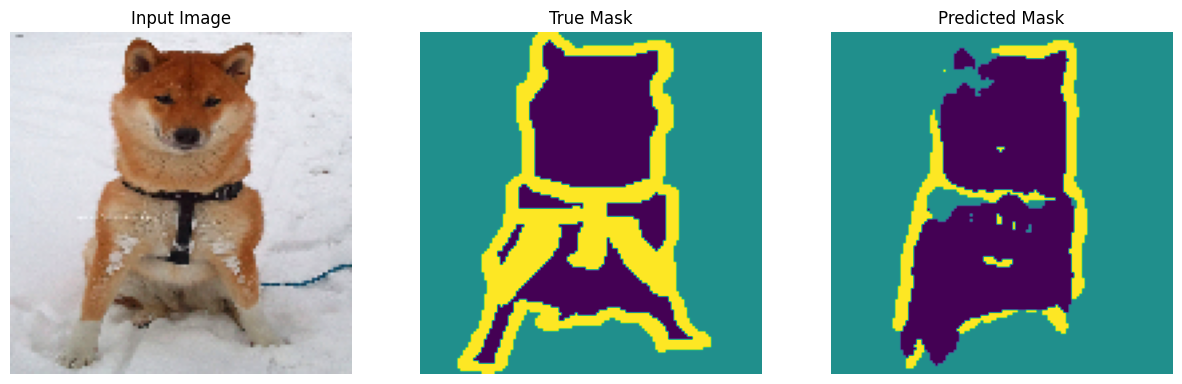

1/1 [==============================] - 0s 12ms/step


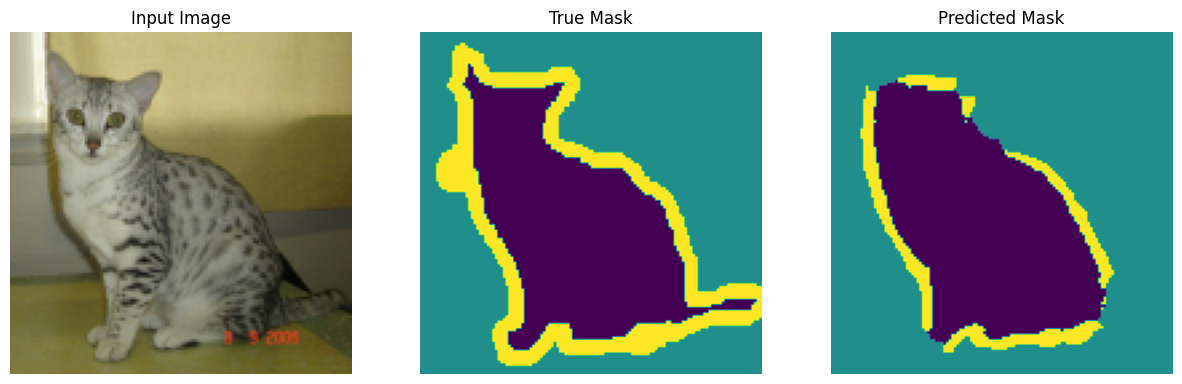

2/2 [==============================] - 0s 27ms/step


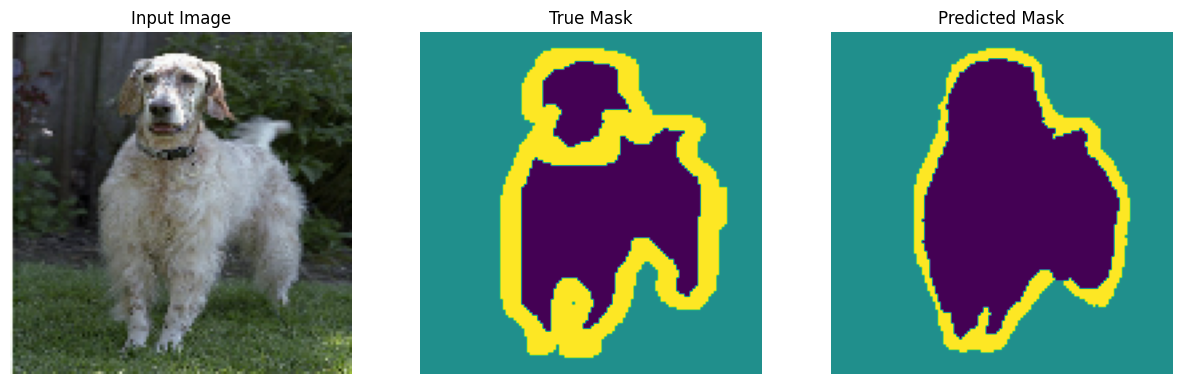

2/2 [==============================] - 0s 28ms/step


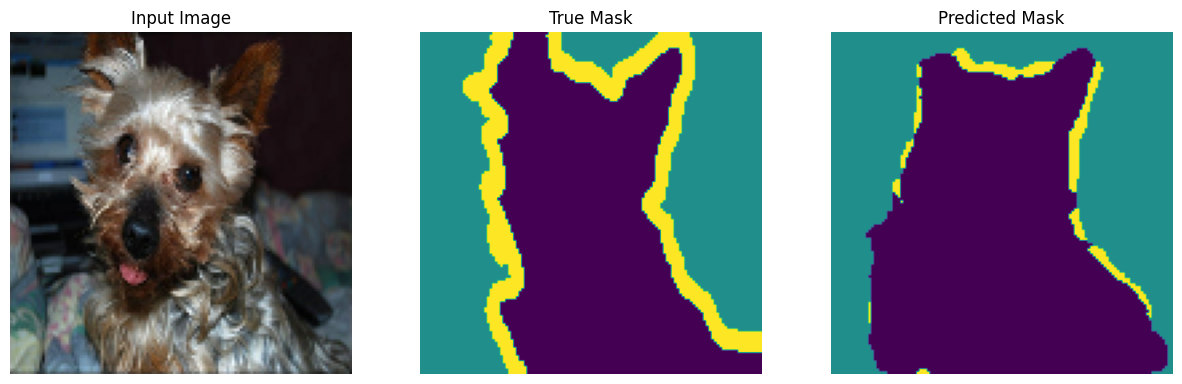

In [38]:
show_predictions(test_batches.shuffle(info.splits["test"].num_examples // 5), 5)

In [24]:
for x, y in test_batches.take(1):
    print(tf.expand_dims(tf.argmax(model.predict(x), axis=-1), axis=-1).shape)
    print(y.shape)
    # display([x[0], y[0], create_mask(model.predict(x))])

2/2 [==============================] - 0s 26ms/step
(64, 128, 128, 1)
(64, 128, 128, 1)


2023-05-30 22:01:13.079422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [3]
	 [[{{node Placeholder/_2}}]]
2023-05-30 22:01:13.079656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]


### Heatmap

1/1 [==============================] - 0s 10ms/step


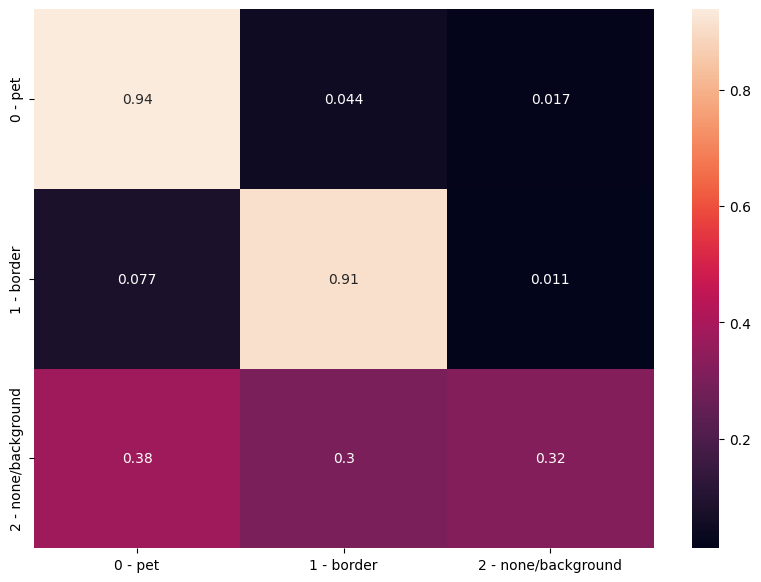

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

matrix = tf.math.confusion_matrix(
    labels=tf.reshape(tf.concat([y for _, y in test_batches], axis=0), -1),
    predictions=tf.reshape(
        tf.concat(
            [
                tf.expand_dims(tf.argmax(model.predict(x), axis=-1), axis=-1)
                for x, y in test_batches
            ],
            axis=0,
        ),
        -1,
    ),
)

float_matrix = tf.cast(matrix, dtype=tf.float32)

matrix = float_matrix / tf.reduce_sum(float_matrix, axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(
    matrix,
    index=["0 - pet", "1 - border", "2 - none/background"],
    columns=["0 - pet", "1 - border", "2 - none/background"],
)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True)
plt.show()